# Time-Series Prediction: Kaggle Bike Sharing Demand

@satishkt @sialan

Lorem ipsum delorum...

In [111]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

import math
import random
from datetime import datetime, date, time

import numpy as np
import pandas as pd
import statsmodels.api as sm

from sklearn import cross_validation
from sklearn import feature_extraction
from sklearn.preprocessing import OneHotEncoder
from sklearn.grid_search import GridSearchCV
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

In [56]:
# Load the data, which is included in sklearn.
bike_sharing_demand = pd.read_csv('./data/input/train.csv')
prediction_data = pd.read_csv('./data/input/test.csv')
print bike_sharing_demand.shape

train_data, train_labels = bike_sharing_demand.ix[:, 'datetime':'windspeed'], bike_sharing_demand.ix[:, 'casual':]
prediction_data = prediction_data.ix[:, 'datetime':'windspeed']

# Set the randomizer seed so results are the same each time.
np.random.seed(0)

# Shuffle the input: create a random permutation of the integers between 0 and the number of data points and apply this
# permutation to X and Y.
# NOTE: Each time you run this cell, you'll re-shuffle the data, resulting in a different ordering.
shuffle = np.random.permutation(np.arange(train_data.shape[0]))
mini_bike_sharing_demand = bike_sharing_demand.ix[shuffle[:100], :]
mini_train_data, mini_train_labels = train_data.ix[shuffle[:100], :], train_labels.ix[shuffle[:100], :]
print mini_train_data.shape, mini_train_labels.shape

print train_data.columns
print train_data.dtypes
print train_labels.columns
print train_labels.dtypes

(10886, 12)
(100, 9) (100, 3)
Index([u'datetime', u'season', u'holiday', u'workingday', u'weather', u'temp', u'atemp', u'humidity', u'windspeed'], dtype='object')
datetime       object
season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
dtype: object
Index([u'casual', u'registered', u'count'], dtype='object')
casual        int64
registered    int64
count         int64
dtype: object


## Data Exploration

Let's get a better handle on what we're working with...

In [3]:
# TODO: Data Exploration
# g = sns.pairplot(mini_bike_sharing_demand.ix[:, 'temp':'casual'], hue="casual", palette="Set2", diag_kind="kde", size=2.5)

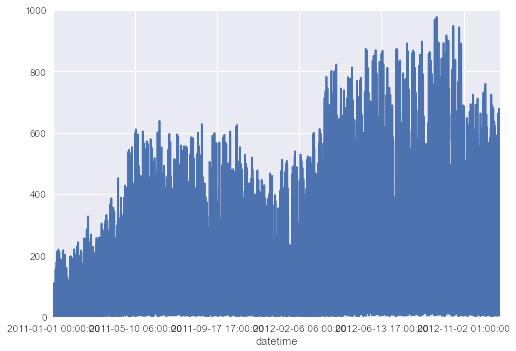

In [33]:
indexed_df = bike_sharing_demand.set_index('datetime').ix[:, 'count']
indexed_df.plot()

In order to get the value of the information in the timestamp, we need to extract it. We'll cover some more advanced feature engineering later on but this should help us out of the gate.

In [57]:
# Let's extract the information
for dataset in (train_data, prediction_data):
    dataset['hour'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).hour)
    dataset['weekday'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).weekday())
    dataset['month'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).month)
    dataset['year'] = dataset['datetime'].map(lambda x: (datetime.strptime(x, "%Y-%m-%d %H:%M:%S")).year)

train_data.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,weekday,month,year
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0,0,5,1,2011
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0,1,5,1,2011
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0,2,5,1,2011
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0,3,5,1,2011
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0,4,5,1,2011


## Evaluation Metrics

Before we move onto modelling, we can define a few functions to use going forward...

In [32]:
# Define the Root-Mean-Squared-Log Error function for scoring predictions
def rmsle(actual_values, predicted_values):
    squared_log_errors = (np.log(np.array(predicted_values) + 1) - np.log(np.array(actual_values) + 1)) ** 2
    mean_squared_errors = np.nansum(squared_log_errors) / len(squared_log_errors)
    return np.sqrt(mean_squared_errors)

# Define cross-validation loop for training and testing
rs = cross_validation.ShuffleSplit(train_data.shape[0], n_iter=10, random_state=0)
for train_index, test_index in rs:
    print("TRAIN:", train_index, "TEST:", test_index)

('TRAIN:', array([ 4677,  4448,  5705, ...,  9845, 10799,  2732]), 'TEST:', array([6638, 7975, 5915, ..., 6860, 9596, 2663]))
('TRAIN:', array([10386,  7496,  9182, ...,  1139,  2328,  2219]), 'TEST:', array([6395, 6832, 9781, ..., 2491, 6925, 6305]))
('TRAIN:', array([ 1287,  6686,  3958, ...,  4151,   665, 10420]), 'TEST:', array([ 2075,  2707,  6480, ..., 10843,  7669,  2231]))
('TRAIN:', array([5623, 5232, 5102, ..., 9615,  495, 1377]), 'TEST:', array([4024, 5941,   16, ..., 6469,  573, 3649]))
('TRAIN:', array([ 121, 2774, 6844, ..., 9362, 6073, 8646]), 'TEST:', array([5481, 8121, 7550, ..., 5653, 6203, 3524]))
('TRAIN:', array([3211, 3162, 1709, ...,  459, 1169, 3559]), 'TEST:', array([7341, 6238, 9430, ..., 9801, 5258, 5785]))
('TRAIN:', array([ 2695,  8909,  7979, ...,  3635, 10203,  2596]), 'TEST:', array([7930, 1021, 4776, ..., 9878, 8776, 1113]))
('TRAIN:', array([3614, 5140,  928, ...,  839, 1852, 1606]), 'TEST:', array([6553, 9310, 1568, ..., 6010,  439, 2633]))
('TRAIN:',

## A Baseline Model (Linear Regression)

Yay.

In [44]:
# Create linear regression object
regr = linear_model.LinearRegression()

# Train the model using the training sets
for i, (train_index, test_index) in enumerate(rs):
    regr.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = regr.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))

Cross-Validated Error Loop 0: 1.17262495536
Cross-Validated Error Loop 1: 1.18423803286
Cross-Validated Error Loop 2: 1.17035666194
Cross-Validated Error Loop 3: 1.15128236819
Cross-Validated Error Loop 4: 1.1208367118
Cross-Validated Error Loop 5: 1.13114804469
Cross-Validated Error Loop 6: 1.14718152976
Cross-Validated Error Loop 7: 1.15876066646
Cross-Validated Error Loop 8: 1.12558267782
Cross-Validated Error Loop 9: 1.15743021669


## A Classical Statistical Forecasting Approach

Traditional approaches to time-series forecasting assume an underlying stochastic process with some degree of stationarity. Using this assumption, auto-regressive (AR) approaches using VAR, ARIMA, or GARCH models are very common. However, unable to capture non-linear feature interaction...ADD MORE

In [7]:
# Let's try some traditional statistical forecasting models, ARIMA
# arma = sm.tsa.ARIMA(src_data_model, order=(1,1,1), freq='W').fit(full_output=False, disp=0)

## A Machine Learning Approach To Time-Series Forecasting

Modern approaches to time-series forecasting leverage chaos theory and the assumption that the underlying process is not random, but ultimately deterministic and highly non-linear...ADD MORE

### K Nearest Neighbors

A non-parametric approach based on ________ paper...ADD MORE

In [8]:
# Create knn regression object
neigh = KNeighborsRegressor(n_neighbors=5)

# Train the model using the training sets
for i, (train_index, test_index) in enumerate(rs):
    neigh.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = neigh.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))

Cross-Validated Error Loop 0: 0.874831380405
Cross-Validated Error Loop 1: 0.816448989085
Cross-Validated Error Loop 2: 0.845769028824
Cross-Validated Error Loop 3: 0.863034482382
Cross-Validated Error Loop 4: 0.824645728344
Cross-Validated Error Loop 5: 0.831427824698
Cross-Validated Error Loop 6: 0.867591377324
Cross-Validated Error Loop 7: 0.836196160394
Cross-Validated Error Loop 8: 0.843380833742
Cross-Validated Error Loop 9: 0.841398341874


### Support Vector Machines

A kernel method based on ____ paper...ADD MORE

In [ ]:
# Create svr objects
svr_lin = SVR(kernel='linear', C=1e3)
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

print("For the SVR using a linear kernel:")
for i, (train_index, test_index) in enumerate(rs):
    svr_lin.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = svr_lin.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))
"""
# Train the model using the training sets
print("For the SVR using an rbf kernel:")
for i, (train_index, test_index) in enumerate(rs):
    svr_rbf.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = svr_rbf.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))
    
# Train the model using the training sets
print("For the SVR using a polynomial kernel or degree 2:")
for i, (train_index, test_index) in enumerate(rs):
    svr_poly.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = svr_poly.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))
"""

### Decision-Tree Based Approaches

RF and GBM extend decision trees....really ensemble methods but we'll cover ensembling multiple models later...

In [43]:
# TODO: Random Forest and GBM Regression
# Create rf and gbm regression object
rf = RandomForestRegressor(random_state=0, n_estimators=100)
gbm = GradientBoostingRegressor(loss='ls', alpha=0.95, n_estimators=500, max_depth=4, learning_rate=.01, min_samples_leaf=9, min_samples_split=9)

# Train the model using the training sets
print("For the Random Forest model:")
for i, (train_index, test_index) in enumerate(rs):
    rf.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = rf.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))
    
# Train the model using the training sets
print("\nFor the Gradient Boosted Trees model:")
for i, (train_index, test_index) in enumerate(rs):
    gbm.fit(train_data.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = gbm.predict(train_data.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))

For the Random Forest model:
Cross-Validated Error Loop 0: 0.357062993623
Cross-Validated Error Loop 1: 0.319521364968
Cross-Validated Error Loop 2: 0.320574357334
Cross-Validated Error Loop 3: 0.340111790106
Cross-Validated Error Loop 4: 0.32492139945
Cross-Validated Error Loop 5: 0.324845814757
Cross-Validated Error Loop 6: 0.325664160057
Cross-Validated Error Loop 7: 0.340137989483
Cross-Validated Error Loop 8: 0.328012599016
Cross-Validated Error Loop 9: 0.32580457893

For the Gradient Boosted Trees model:
Cross-Validated Error Loop 0: 0.59509561285
Cross-Validated Error Loop 1: 0.595152375499
Cross-Validated Error Loop 2: 0.569883383723
Cross-Validated Error Loop 3: 0.613558059052
Cross-Validated Error Loop 4: 0.566935489885
Cross-Validated Error Loop 5: 0.569727251467
Cross-Validated Error Loop 6: 0.550634120313
Cross-Validated Error Loop 7: 0.585498709599
Cross-Validated Error Loop 8: 0.53910777445
Cross-Validated Error Loop 9: 0.551717866881


## Feature Engineering

Now we can start playing with the features...

In [136]:
from sklearn.preprocessing import OneHotEncoder

def one_hot_dataframe(data, cols, replace=False):
    """ Takes a dataframe and a list of columns that need to be encoded.
    Returns a 3-tuple comprising the data, the vectorized data,
    and the fitted vectorizer.
    Modified from https://gist.github.com/kljensen/5452382
    """
    enc = OneHotEncoder()
    e = enc.fit_transform(data[cols].values)
    vecData = pd.DataFrame(e.toarray())
    if replace is True:
        data = data.drop(cols, axis=1)
        data = data.join(vecData)
    return (data, vecData)

In [72]:
# TODO: Add Sliding Windows
# Add windowed features (simple moving average) for weather, temp, atemp, humidity, and windspeed
train_data_windowed_features_three = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 3, 'boxcar')
train_data_windowed_features_six = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 6, 'boxcar')
train_data_windowed_features_twelve = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 12, 'boxcar')
train_data_windowed_features_twentyfour = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 24, 'boxcar')
train_data_windowed_features_fourtyeight = pd.rolling_window(train_data.ix[:, 'temp':'windspeed'], 48, 'boxcar')

prediction_data_windowed_features_three = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 3, 'boxcar')
prediction_data_windowed_features_six = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 6, 'boxcar')
prediction_data_windowed_features_twelve = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 12, 'boxcar')
prediction_data_windowed_features_twentyfour = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 24, 'boxcar')
prediction_data_windowed_features_fourtyeight = pd.rolling_window(prediction_data.ix[:, 'temp':'windspeed'], 48, 'boxcar')

train_data_combined = train_data.copy(deep=False)

train_data_combined['temp_w3'] = train_data_windowed_features_three['temp']
train_data_combined['temp_w6'] = train_data_windowed_features_six['temp']
train_data_combined['temp_w12'] = train_data_windowed_features_twelve['temp']
train_data_combined['temp_w24'] = train_data_windowed_features_twentyfour['temp']
train_data_combined['temp_w48'] = train_data_windowed_features_fourtyeight['temp']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['temp']))

train_data_combined['atemp_w3'] = train_data_windowed_features_three['atemp']
train_data_combined['atemp_w6'] = train_data_windowed_features_six['atemp']
train_data_combined['atemp_w12'] = train_data_windowed_features_twelve['atemp']
train_data_combined['atemp_w24'] = train_data_windowed_features_twentyfour['atemp']
train_data_combined['atemp_w48'] = train_data_windowed_features_fourtyeight['atemp']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['atemp']))

train_data_combined['humidity_w3'] = train_data_windowed_features_three['humidity']
train_data_combined['humidity_w6'] = train_data_windowed_features_six['humidity']
train_data_combined['humidity_w12'] = train_data_windowed_features_twelve['humidity']
train_data_combined['humidity_w24'] = train_data_windowed_features_twentyfour['humidity']
train_data_combined['humidity_w48'] = train_data_windowed_features_fourtyeight['humidity']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['humidity']))

train_data_combined['windspeed_w3'] = train_data_windowed_features_three['windspeed']
train_data_combined['windspeed_w6'] = train_data_windowed_features_six['windspeed']
train_data_combined['windspeed_w12'] = train_data_windowed_features_twelve['windspeed']
train_data_combined['windspeed_w24'] = train_data_windowed_features_twentyfour['windspeed']
train_data_combined['windspeed_w48'] = train_data_windowed_features_fourtyeight['windspeed']
train_data_combined = train_data_combined.apply(lambda x: x.fillna(value=train_data_combined['windspeed']))

train_data_combined.head(10)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,hour,...,humidity_w3,humidity_w6,humidity_w12,humidity_w24,humidity_w48,windspeed_w3,windspeed_w6,windspeed_w12,windspeed_w24,windspeed_w48
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0000,0,...,81.000000,81.000000,81,81,81,0.000000,0.000000,0.0000,0.0000,0.0000
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0000,1,...,80.000000,80.000000,80,80,80,0.000000,0.000000,0.0000,0.0000,0.0000
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0000,2,...,80.333333,80.000000,80,80,80,0.000000,0.000000,0.0000,0.0000,0.0000
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0000,3,...,78.333333,75.000000,75,75,75,0.000000,0.000000,0.0000,0.0000,0.0000
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0000,4,...,76.666667,75.000000,75,75,75,0.000000,0.000000,0.0000,0.0000,0.0000
5,2011-01-01 05:00:00,1,0,0,2,9.84,12.880,75,6.0032,5,...,75.000000,77.666667,75,75,75,2.001067,1.000533,6.0032,6.0032,6.0032
6,2011-01-01 06:00:00,1,0,0,1,9.02,13.635,80,0.0000,6,...,76.666667,77.500000,80,80,80,2.001067,1.000533,0.0000,0.0000,0.0000
7,2011-01-01 07:00:00,1,0,0,1,8.20,12.880,86,0.0000,7,...,80.333333,78.500000,86,86,86,2.001067,1.000533,0.0000,0.0000,0.0000
8,2011-01-01 08:00:00,1,0,0,1,9.84,14.395,75,0.0000,8,...,80.333333,77.666667,75,75,75,0.000000,1.000533,0.0000,0.0000,0.0000
9,2011-01-01 09:00:00,1,0,0,1,13.12,17.425,76,0.0000,9,...,79.000000,77.833333,76,76,76,0.000000,1.000533,0.0000,0.0000,0.0000


One hot encoding!

In [137]:
train_data_processed, _ = one_hot_dataframe(train_data_combined, ['season', 'holiday', 'workingday', 'weather', 'hour', 'weekday', 'month', 'year'], replace=True)

In [12]:
# TODO: Add some techniques from signal processing

## Feature Selection

Now that we've built more features, we need to do some feature selection...ADD MORE

## Modelling: Round Two!

Time to try some of these models again with the advanced features...this time we'll optimize the parameters also...ADD MORE

In [139]:
rf = RandomForestRegressor(random_state=0, n_estimators=100)

# Train the model using the training sets
print("For the Random Forest model:")
for i, (train_index, test_index) in enumerate(rs):
    rf.fit(train_data_combined.ix[train_index, 'season':], train_labels.ix[train_index, 'count'])
    prediction_values = rf.predict(train_data_combined.ix[test_index, 'season':])
    print("Cross-Validated Error Loop {0}: {1}".format(i, rmsle(train_labels.ix[test_index, 'count'], prediction_values)))

For the Random Forest model:
Cross-Validated Error Loop 0: 0.385209058287
Cross-Validated Error Loop 1: 0.343968701309
Cross-Validated Error Loop 2: 0.341783672202
Cross-Validated Error Loop 3: 0.363716612971
Cross-Validated Error Loop 4: 0.353490401761
Cross-Validated Error Loop 5: 0.348524079696
Cross-Validated Error Loop 6: 0.340564216447
Cross-Validated Error Loop 7: 0.358355907028
Cross-Validated Error Loop 8: 0.344382227124
Cross-Validated Error Loop 9: 0.349259676984


## Ensembling!

Now that we have our models all tuned, we can ensemble them together for superior performance...ADD MORE

## Submitting

For kaggle, we can simply build a csv using the sample submission

In [15]:
# For now train using the RF model on the entire training set
rf = RandomForestRegressor(random_state=0)

# Set the parameters by cross-validation
param_grid = {'n_estimators': [100, 300, 500, 700, 1000], 'max_depth': [None, 1, 2, 3, 5], 'min_samples_split': [1, 2, 3, 5]}
model = GridSearchCV(rf, param_grid=param_grid)
model.fit(train_data.ix[:, 'season':], train_labels.ix[:, 'count'])

# Make predictions
prediction_values = model.predict(prediction_data.ix[:, 'season':])

# Create submission from sample_submission file
submission_df = pd.read_csv('./data/output/sampleSubmission.csv')
submission_df['count'] = prediction_values
submission_df.to_csv('./data/output/rf_tuned_windowedfeatures.csv', index=False)

What have we learned?...

## APPENDIX: Deep Learning

So using supervised learning, the sliding window approaches proved to be instrumental and feature engineering is obviously super important. However, with the modern advances in ML over the last few years, we can achieve the same (or superior) performance without domain-specific features. See LINK for tutorial, but ultimately the importance of Deep Learning is representation learning...ADD MORE

In [ ]:
# TODO: RBM, Stacked Auto-encoders, DBN, CNN and RNN?